In [1]:
from qibo.gates import I, X, RX, RY, M, CZ, Y, Z
import numpy as np
from qibo.models import Circuit
from itertools import product

from utils.qst_qpt_helper_functions import *

from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

import datetime

api = API(ConnectionConfiguration(username="qat", api_key="meow"))

api.select_device_id(9)

#### Constants

In [2]:
NUM_SHOTS = 1000

#### Define basic gate sequence

In [3]:
def six_operators(qubit):
    return [
        I(qubit),
        X(qubit),
        RX(qubit, np.pi / 2),
        RX(qubit, -np.pi / 2),
        RY(qubit, np.pi / 2),
        RY(qubit, -np.pi / 2),
    ]

#### Define circuits for process tomography of the CZ gate and for obtaining the SPAM matrix

In [4]:
def process_tomography(pa, qubit_a, qubit_b):
    """Returns tomography circuits for the 6 different states in qubit B.

    Args:
        pa (qibo.gates.gates): gate assigning the preparation of qubit A.
        qubit_a (int_): first qubit
        qubit_b (int): second qubit

    Returns:
        circuits: list containing the generated tomography circuits.
    """
    circuits = []

    for pb in six_operators(qubit_b):
        for op1_a in six_operators(qubit_a):
            for op1_b in six_operators(qubit_b):
                circuit = Circuit(5)
                circuit.add(pa)  # PA
                circuit.add(pb)  # PB
                circuit.add(CZ(qubit_a, qubit_b))
                circuit.add(op1_a)  # RA
                circuit.add(op1_b)  # RB
                circuit.add(M(qubit_a, qubit_b))

                circuits.append(circuit)
    return circuits


def spam_matrix_circuits(qubit_a, qubit_b):
    circuits = []
    for gate_a in [I, X]:
        for gate_b in [I, X]:
            circuit = Circuit(5)
            circuit.add(gate_a(qubit_a))
            circuit.add(gate_b(qubit_b))
            circuit.add(M(qubit_a, qubit_b))

            circuits.append(circuit)

    return circuits

#### Run sequences
We separate the data coming from each post-CZ basis state reconstruction in order to go around the 1000 circuit limit per execute call.

In [5]:
qubit_pairs = [(0, 2), (1, 2), (2, 3), (2, 4)]

spam_job_ids = {}
qpt_job_ids = {}


for qubit_pair in qubit_pairs:
    QUBIT_A, QUBIT_B = qubit_pair

    ## Run SPAM measurements, store ID
    spam_circuits = spam_matrix_circuits(QUBIT_A, QUBIT_B)
    result_id = api.execute(spam_circuits, nshots=NUM_SHOTS)[0]
    spam_job_ids[str(qubit_pair)] = result_id

    qst_jobids = {}

    ## Run QPT measurements, store ID
    for i, pa in enumerate(six_operators(QUBIT_A)):
        state_tomography_circuits = process_tomography(pa, QUBIT_A, QUBIT_B)
        result_id = api.execute(state_tomography_circuits, nshots=NUM_SHOTS)[0]

        qst_jobids[str(i)] = result_id

    qpt_job_ids[str(qubit_pair)] = qst_jobids

#### Save job ids in .txt

In [6]:
today = datetime.datetime.now()
date_stamp = ("").join([str(x) for x in [today.year, today.month, today.day]])
time_stamp = ("").join([str(x) for x in [today.hour, today.minute, today.second]])
fpath_saveids = f"./qpt_job_ids_{date_stamp}_{time_stamp}.txt"
print(fpath_saveids)

./qpt_job_ids_20231128_191158.txt


In [7]:
with open(fpath_saveids, "w") as f:
    for qubit_pair in qubit_pairs:
        f.write("####" + str(qubit_pair) + "\n")
        f.write("spam" + "\t" + str(spam_job_ids[str(qubit_pair)]) + "\n")

        f.write("qpt" + "\t")
        for x in qpt_job_ids[str(qubit_pair)].values():
            f.write(str(x) + "\t")
        f.write("\n")

#### Retrieve jobs from .txt

In [8]:
def retrieve_jobids(fpath_saveids):
    spam_job_ids = {}
    qpt_job_ids = {}
    with open(fpath_saveids, "r") as f:
        for line in f.readlines():
            if line[:4] == "####":
                qubit_pair = (int(line[5]), int(line[8]))
            elif line[:4] == "spam":
                spam_job_ids[str(qubit_pair)] = int(line[5:-1])
            elif line[:3] == "qpt":
                qst_jobids = {}
                for i, x in enumerate(line.split("\t")[1:-1]):
                    qst_jobids[str(i)] = int(x)
                qpt_job_ids[str(qubit_pair)] = qst_jobids
    return spam_job_ids, qpt_job_ids


spam_job_ids, qpt_job_ids = retrieve_jobids(fpath_saveids)

In [32]:
api.list_jobs().dataframe[:40]

{
  "title": "Unauthorized",
  "status": 401,
  "detail": "JWTExpired: Error verifying the authorisation access token. Expired at 1701082080, time: 1701082525(leeway: 60) 401 Client Error:  for url: https://qilimanjaroqaas.ddns.net:8080/api/v1/jobs?favourites=False"
}
{"title":"Unauthorized","status":401,"detail":"JWTExpired: Error verifying the authorisation access token. Expired at 1701082080, time: 1701082525(leeway: 60)"}



,user_id,device_id,status,job_type,number_shots,id
0,86,9,completed,circuit,1000,6898
1,86,9,completed,circuit,1000,6897
2,86,9,completed,circuit,1000,6896
3,86,9,completed,circuit,1000,6895
4,86,9,completed,circuit,1000,6894
5,86,9,completed,circuit,1000,6893
6,86,9,completed,circuit,1000,6892
7,86,9,completed,circuit,1000,6891
8,86,9,completed,circuit,1000,6890
9,86,9,completed,circuit,1000,6889


### Analyse data

In [33]:
qubit_pairs = [(0, 2), (1, 2), (2, 3), (2, 4)]

state_reconstruction_paulibasis = np.zeros((len(qubit_pairs), 36, 16))

ideal_operator = CZ(0, 1).matrix
R_ideal = get_ideal_R_matrix(ideal_operator)

reconstructed_Rs = np.zeros((len(qubit_pairs), 16, 16))
fidelities = {}


for pair_index, qubit_pair in enumerate(qubit_pairs):
    spam_id = spam_job_ids[str(qubit_pair)]
    spam_results = api.get_result(spam_id)
    spam_data_probabilities = process_returned_dataformat(spam_results, nqubits=2)
    coeffs_mat_spam, ideal_measurements_spam = prepare_linear_system_measurement_calibration(spam_data_probabilities)
    measurement_calibration_weights = np.linalg.solve(coeffs_mat_spam, ideal_measurements_spam).reshape(3, 4)
    measurement_calibration_weights = np.linalg.pinv(measurement_calibration_weights)

    P_index = 0
    for pa_index in range(6):
        qst_pa_id = qpt_job_ids[str(qubit_pair)][str(pa_index)]
        qst_pa_results = api.get_result(qst_pa_id)
        qst_pa_probabilities = process_returned_dataformat(qst_pa_results, nqubits=2)
        qst_pa_expectedobs = convert_probabilities2measurementops(qst_pa_probabilities)

        for pb_index in range(6):
            qst_papb_expectedobs = qst_pa_expectedobs[pb_index * 36 : 36 * (pb_index + 1)]
            coeff_matrix, independent_term = prepare_linear_system_QST(
                measurement_calibration_weights, qst_papb_expectedobs
            )

            ## solve linear system QST
            reconstructed_state_paulibasis_noII = np.linalg.pinv(coeff_matrix) @ independent_term
            state_reconstruction_paulibasis[pair_index, P_index] = np.append(1 / 4, reconstructed_state_paulibasis_noII)

            P_index += 1

    coeffs_mat, independent_term = prepare_linear_system_QPT(state_reconstruction_paulibasis[pair_index])
    Rvec = np.linalg.pinv(coeffs_mat) @ independent_term
    reconstructed_R = Rvec.reshape(16, 16)
    reconstructed_Rs[pair_index] = reconstructed_R

    process_fidelity = compute_process_fidelity(R_ideal, reconstructed_R)
    fidelities[str(qubit_pair)] = process_fidelity

Your job with id 6871 is completed.
Your job with id 6872 is completed.
Your job with id 6873 is completed.
Your job with id 6874 is completed.
Your job with id 6875 is completed.
Your job with id 6876 is completed.
Your job with id 6877 is completed.
Your job with id 6878 is completed.
Your job with id 6879 is completed.
Your job with id 6880 is completed.
Your job with id 6881 is completed.
Your job with id 6882 is completed.
Your job with id 6883 is completed.
Your job with id 6884 is completed.
Your job with id 6885 is completed.
Your job with id 6886 is completed.
Your job with id 6887 is completed.
Your job with id 6888 is completed.
Your job with id 6889 is completed.
Your job with id 6890 is completed.
Your job with id 6891 is completed.
Your job with id 6892 is completed.
Your job with id 6893 is completed.
Your job with id 6894 is completed.
Your job with id 6895 is completed.
Your job with id 6896 is completed.
Your job with id 6897 is completed.
Your job with id 6898 is com

In [34]:
print(fidelities)

{'(0, 2)': 0.2988465003555485, '(1, 2)': 0.3985101152262467, '(2, 3)': 0.5460456071276376, '(2, 4)': 0.8815892777632635}


In [35]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from pandas import DataFrame

In [36]:
def plot_R(R_mat, title=None, ax=None, fig=None):
    xlabels = ["II", "IX", "IY", "IZ", "XI", "XX", "XY", "XZ", "YI", "YX", "YY", "YZ", "ZI", "ZX", "ZY", "ZZ"]

    r_df = DataFrame(R_mat * (2**2), index=xlabels, columns=xlabels)
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))
    ax = heatmap(r_df, vmin=-4, vmax=4, ax=ax)
    if title is not None:
        ax.set_title(title)
    return fig, ax

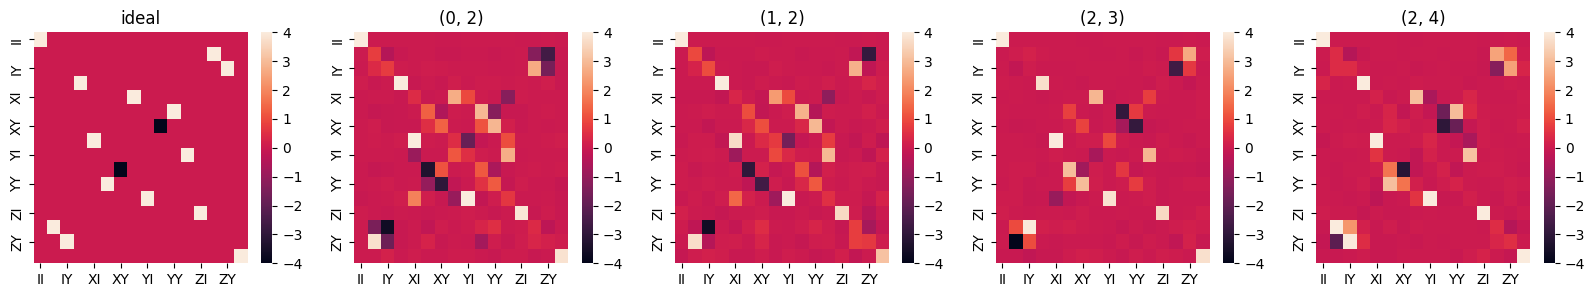

In [37]:
figsize = (3, 3)
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
fig, axes[0] = plot_R(R_ideal, title="ideal", ax=axes[0], fig=fig)
for i in range(4):
    fig, axes[i + 1] = plot_R(reconstructed_Rs[i], title=str(qubit_pairs[i]), ax=axes[i + 1])